In [1]:
# import necessary libaries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.io import output_notebook

%matplotlib inline

In [2]:
output_notebook()

Loading BokehJS ...

## Notes:

#### GOAL: Determine whether Smartly or Nanigans delivers a better ad performance (based on Cost per Acquisition)

#### The study is randomized with equal weight given to Smartly / Nanigans (50/50) with no users seeing ads from both FMPs

#### Study is being run from 11-14-2017 (1230) to 11-30-2017 (1330)

#### Attribution: 28 day click, no view through 

#### Spent Column is given in 'cents'

### Assumptions:

#### Audience is the same for smartly and nanigans ads (50/50 random split)

#### November 14th is the first day ads ran for both FMPs (conversions occurring over the given time period are not attributable to ads that ran prior to 11-14)

#### Ad study began and ended at the same time for both FMPs

### Notebook Outline:

     1) Loading & Cleaning Data 
     2) Exploring Smartly & Nanigans and Determining CPA
     3) Making Comparisons & Checking for Significance
     4) Insights & Conclusions

----

# 1) Loading and Cleaning Data

In [3]:
# import the data

data = 'AnalyticsExerciseDataOriginal.csv'
df = pd.read_csv(data)

In [4]:
# display the top 5 entries to visualize the dataset

df.head()

,cell,adgroup_id,date,spent,impressions,clicks,conversions
0,nanigans,5a0ad96be6b83b6df54da177,2017-11-14,2583,1026,19,6
1,nanigans,5a0ad96be6b83b6df54da177,2017-11-15,1819,744,14,1
2,nanigans,5a0ad96be6b83b6df54da177,2017-11-21,555,272,1,0
3,nanigans,5a0ad96be6b83b6df54da179,2017-11-14,2793,1063,13,4
4,nanigans,5a0ad96be6b83b6df54da179,2017-11-15,1714,702,5,3


In [5]:
# Get an overview of what the dataset contains

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cell         322 non-null    object
 1   adgroup_id   322 non-null    object
 2   date         322 non-null    object
 3   spent        322 non-null    int64 
 4   impressions  322 non-null    int64 
 5   clicks       322 non-null    int64 
 6   conversions  322 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 17.7+ KB


- This dataset contains 322 rows and 7 columns
- The first 3 columns are strings, the remaining 4 are numerical features

In [6]:
df.shape

(322, 7)

### Convert the date column from 'object' type to 'datetime' 

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
# Verify the date column was converted

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   cell         322 non-null    object        
 1   adgroup_id   322 non-null    object        
 2   date         322 non-null    datetime64[ns]
 3   spent        322 non-null    int64         
 4   impressions  322 non-null    int64         
 5   clicks       322 non-null    int64         
 6   conversions  322 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 17.7+ KB


### Because Dollars are easier for most people to understand, the 'Spent' column will be converted from cents to dollars

In [9]:
df['spent'] = round(df['spent'] / 100 , 2)
print(df['spent'])

0       25.83
1       18.19
2        5.55
3       27.93
4       17.14
        ...  
317    231.69
318    185.52
319    200.21
320    191.55
321    208.72
Name: spent, Length: 322, dtype: float64


### Checking for missing values

In [10]:
df.isnull().sum()

cell           0
adgroup_id     0
date           0
spent          0
impressions    0
clicks         0
conversions    0
dtype: int64

Yay! There appear to be no missing values

### Looking at the number of unique values

In [11]:
df.nunique()

cell             2
adgroup_id      61
date            15
spent          303
impressions    299
clicks          89
conversions     56
dtype: int64

I used the nunique() method, however, I was only interested in the first few

- As stated, only Smartly and Nanigans data are included in this dataset (Cell col)
- Eventhough there are 17 days in which the test was run, there appear to only be 15 unique dates. Will need to explore further

### Examining Dates

In [12]:
min_date = df['date'].min()
max_date = df['date'].max()
print(min_date , max_date)

2017-11-14 00:00:00 2017-11-28 00:00:00


It appears that the last ad ran / converted on 2017-11-28 , despite the test being run until the 30th. This would account for the 2 day discrepancy seen in the number of unique dates above. To be certain, we'll look at all the unique dates to verify there are no gaps.

In [13]:
dates = df['date'].unique()
print(sorted(dates))

[numpy.datetime64('2017-11-14T00:00:00.000000000'), numpy.datetime64('2017-11-15T00:00:00.000000000'), numpy.datetime64('2017-11-16T00:00:00.000000000'), numpy.datetime64('2017-11-17T00:00:00.000000000'), numpy.datetime64('2017-11-18T00:00:00.000000000'), numpy.datetime64('2017-11-19T00:00:00.000000000'), numpy.datetime64('2017-11-20T00:00:00.000000000'), numpy.datetime64('2017-11-21T00:00:00.000000000'), numpy.datetime64('2017-11-22T00:00:00.000000000'), numpy.datetime64('2017-11-23T00:00:00.000000000'), numpy.datetime64('2017-11-24T00:00:00.000000000'), numpy.datetime64('2017-11-25T00:00:00.000000000'), numpy.datetime64('2017-11-26T00:00:00.000000000'), numpy.datetime64('2017-11-27T00:00:00.000000000'), numpy.datetime64('2017-11-28T00:00:00.000000000')]


#### The dates from 2017-11-14 to 2017-11-28 contain no gaps

----

# Exploring FMPs individually and calculating their CPA 

### To start analyzing which FMP performed best, we'll start by splitting the initial dataset into 2 separate datasets. 1 for Smartly ads and 1 for Nanigans 

In [14]:
# Looking at the distribution of Smartly to Nanigans data

smartly = df[df['cell'] == 'smartly']
nanigans  = df[df['cell'] == 'nanigans']

print('Smartly: {:d}, Nanigans: {:d}'.format(len(smartly), len(nanigans)))

Smartly: 23, Nanigans: 299


#### Interestingly there appears to only be 23 observations for Smartly to Nanigans' 299

# Smartly

In [15]:
# creating a smartly dataframe and reindexing
df_smartly = df[df['cell'] == 'smartly'].reset_index(drop=True)

# creating a Cost per Click (CPC), Cost per Thousand Impressions (CPM) and Cost per Acquisition (CPA) cols
df_smartly['CPM'] = round(df_smartly['spent'] / df_smartly['impressions'], 2)
df_smartly['CPC'] = round(df_smartly['spent'] / df_smartly['clicks'], 2)
df_smartly['CPA'] = round(df_smartly['spent'] / df_smartly['conversions'], 2)

# set the index to date for timeseries plotting
df_smartly = df_smartly.set_index('date')

df_smartly.head()

,cell,adgroup_id,spent,impressions,clicks,conversions,CPM,CPC,CPA
date,,,,,,,,,
2017-11-14,smartly,5a0ada56c7e28c71086d74b8,254.75,12903,254,117,0.02,1.00,2.18
2017-11-15,smartly,5a0ada56c7e28c71086d74b8,500.27,22922,365,184,0.02,1.37,2.72
2017-11-16,smartly,5a0ada56c7e28c71086d74b8,446.85,19455,403,170,0.02,1.11,2.63
2017-11-17,smartly,5a0ada56c7e28c71086d74b8,365.01,15387,257,95,0.02,1.42,3.84
2017-11-18,smartly,5a0ada56c7e28c71086d74b8,146.03,6659,101,36,0.02,1.45,4.06


In [16]:
df_smartly.shape

(23, 9)

In [17]:
# How many unique adgroups are there?

df_smartly['adgroup_id'].nunique()

3

Smartly ran 3 adgroups over the course of the study

In [18]:
df_smartly.describe()

,spent,impressions,clicks,conversions,CPM,CPC,CPA
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,265.160870,13689.043478,314.391304,113.695652,0.019565,0.865652,2.406087
std,158.208504,7909.680677,179.914308,65.449102,0.002085,0.281147,0.759442
min,31.120000,1595.000000,32.000000,12.000000,0.010000,0.410000,0.640000
25%,165.775000,8251.000000,235.500000,74.500000,0.020000,0.685000,2.040000
50%,231.690000,12220.000000,287.000000,95.000000,0.020000,0.860000,2.590000
75%,413.055000,19152.000000,385.000000,169.000000,0.020000,0.970000,2.705000
max,509.340000,29493.000000,687.000000,257.000000,0.020000,1.450000,4.060000


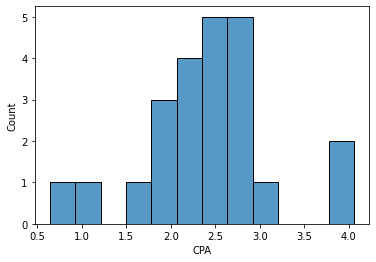

In [19]:
# Visualizing the distribution of Cost per Acquisition

sns.histplot(data=df_smartly, x="CPA", bins=12)
plt.show()

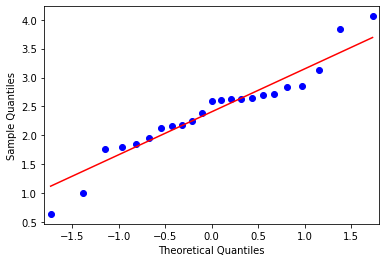

In [20]:
'''A Q-Q plot is another way to test whether a sample set is
   normally distributed. For this, we can compare the emperical (observed)
   quantiles against the quantiles of the known (Normal) theoretical 
   quantiles'''

sm.ProbPlot(df_smartly['CPA']).qqplot(line='s');

#### While there are only 23 observations, it appears that the distribution might not be quite Gaussian

In [21]:
# For interest sakes, I wanted to see how CPA varies throughout the week
# Are there any days that seem to perform better?

# Resample all ad group data into 'days of the week'
df_smartly_wkday = df_smartly.drop(columns=['CPM','CPC','CPA']).resample('D').sum()
# Add col for a given day's CPA
df_smartly_wkday['CPA'] = round(df_smartly_wkday['spent'] / df_smartly_wkday['conversions'], 2)
# Add a col for the date's respective weekday
df_smartly_wkday['weekday'] = pd.DatetimeIndex(df_smartly_wkday.index).to_series().dt.day_name()
df_smartly_wkday.head()

,spent,impressions,clicks,conversions,CPA,weekday
date,,,,,,
2017-11-14,254.75,12903,254,117,2.18,Tuesday
2017-11-15,539.60,25175,460,245,2.20,Wednesday
2017-11-16,562.01,25647,664,284,1.98,Thursday
2017-11-17,599.78,26553,583,222,2.70,Friday
2017-11-18,590.10,25508,584,204,2.89,Saturday


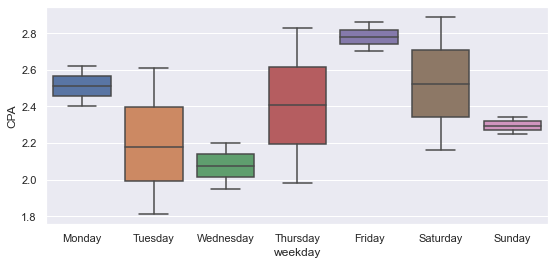

In [22]:
# Visualizing CPA by Day of the Week

sns.set(rc={'figure.figsize':(9, 4)})
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.boxplot(x="weekday", y="CPA", data=df_smartly_wkday, order=order)
plt.show()

### Here we can see that Smartly's daily CPA varies little and is in the range of  \\$1.80 - \\$2.90

In [23]:
# Determining how much Smartly spent in total and the average CPA

smartly_total_spend = df_smartly['spent'].sum()
smartly_avg_cpa = df_smartly['CPA'].mean()
smartly_tot_conv = df_smartly['conversions'].sum()

print('In total, Smartly spent ${0:.2f} on this ad study which generated {1} conversions with an average CPA of ${2:.2f}'.format(smartly_total_spend,smartly_tot_conv,smartly_avg_cpa))

In total, Smartly spent $6098.70 on this ad study which generated 2615 conversions with an average CPA of $2.41


In [24]:
# ROAS is another great way to quantify campaign performance
# Return on ad spend (ROAS) calculation

def return_on_ad_spend(ad_spend, conversions, rev_per_conv):
    ROAS = (conversions * rev_per_conv) / ad_spend
    return ROAS
    

In [25]:
# Sample calculation using a product priced at $10

product_price = 10
ROAS = return_on_ad_spend(smartly_total_spend, smartly_tot_conv, product_price)

print('For every dollar spent on ads, Smartly generated ${0:.2f} in revenue'.format(ROAS))

For every dollar spent on ads, Smartly generated $4.29 in revenue


#### We could look at the ROAS for each individual adgroup, however, we're only focused on CPA for this assignment

----

# Nanigans

In [26]:
# Create nanigans dataframe
df_nanigans = df[df['cell'] == 'nanigans'].reset_index(drop=True)

# creating a Cost per Click (CPC), Cost per Thousand Impressions (CPM) and Cost per Acquisition (CPA) cols
df_nanigans['CPM'] = round(df_nanigans['spent'] / df_nanigans['impressions'], 2)
df_nanigans['CPC'] = round(df_nanigans['spent'] / df_nanigans['clicks'], 2)
df_nanigans['CPA'] = round(df_nanigans['spent'] / df_nanigans['conversions'], 2)

# set index to date for timeseries plotting
df_nanigans = df_nanigans.set_index('date')

df_nanigans.head()

,cell,adgroup_id,spent,impressions,clicks,conversions,CPM,CPC,CPA
date,,,,,,,,,
2017-11-14,nanigans,5a0ad96be6b83b6df54da177,25.83,1026,19,6,0.03,1.36,4.30
2017-11-15,nanigans,5a0ad96be6b83b6df54da177,18.19,744,14,1,0.02,1.30,18.19
2017-11-21,nanigans,5a0ad96be6b83b6df54da177,5.55,272,1,0,0.02,5.55,inf
2017-11-14,nanigans,5a0ad96be6b83b6df54da179,27.93,1063,13,4,0.03,2.15,6.98
2017-11-15,nanigans,5a0ad96be6b83b6df54da179,17.14,702,5,3,0.02,3.43,5.71


In [27]:
df_nanigans.shape

(299, 9)

In [28]:
# How many unique adgroups are there?

df_nanigans['adgroup_id'].nunique()

58

In [29]:
df_nanigans.describe()

,spent,impressions,clicks,conversions,CPM,CPC,CPA
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.00,299.000
mean,19.898194,967.719064,19.652174,7.297659,0.021940,inf,inf
std,16.618609,916.272626,26.844308,8.437792,0.005141,NaN,NaN
min,0.040000,2.000000,0.000000,0.000000,0.010000,0.25,0.390
25%,7.465000,302.000000,2.000000,1.000000,0.020000,0.91,2.245
50%,15.480000,757.000000,10.000000,5.000000,0.020000,1.72,3.980
75%,27.420000,1251.500000,25.500000,10.500000,0.020000,3.25,9.580
max,88.410000,5487.000000,168.000000,50.000000,0.040000,inf,inf


#### From the summary description, we can see that nanigans used a cost per thousand impressions strategy for at least some adgroups, meaning that money was spent on ads that were viewed but neither clicked on nor converted. Additionally, we can see that several ads were clicked on but didn't convert (inf values)

In [30]:
# How much was spent on ads that were view, but neither clicked or converted?

nanigans_CPM_nc_spend = df_nanigans.loc[df_nanigans['clicks'] == 0, 'CPM'].sum()
nanigans_CPM_nc_count = df_nanigans.loc[df_nanigans['clicks'] == 0, 'CPM'].count()

print('Nanigans spent ${0} on {1} ads that were viewed, but did not convert'.format(nanigans_CPM_nc_spend, nanigans_CPM_nc_count))

Nanigans spent $0.73 on 34 ads that were viewed, but did not convert


In [31]:
# Removing rows for the 34 rows that totaled $0.73 in ad spend
# These only really account for time spent on making the ads

df_nanigans = df_nanigans[df_nanigans['clicks'] != 0]
df_nanigans.shape

(265, 9)

#### While still important to account for, these 34 non-converting CPM ads will be dropped due to having a very small impact overall

In [32]:
# How much was spent on ads that were clicked, but didn't lead to a conversion?

nanigans_CPC_nc_spend = df_nanigans.loc[(df_nanigans.clicks != 0) & (df_nanigans.conversions == 0), 'CPC'].sum()
nanigans_CPC_nc_count = df_nanigans.loc[(df_nanigans.clicks != 0) & (df_nanigans.conversions == 0), 'CPC'].count()

print('Nanigans spent ${0} on {1} ads that were clicked, but did not convert'.format(nanigans_CPC_nc_spend, nanigans_CPC_nc_count))

Nanigans spent $111.85 on 25 ads that were clicked, but did not convert


#### Because the above adgroups were clicked, but didn't convert, they will still be included in the analysis when determining CPA

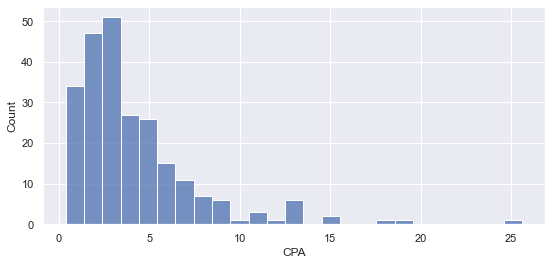

In [33]:
# Visualizing the distribution of Cost per Acquisition 

df_nanigans_conv_only = df_nanigans[df_nanigans['conversions'] != 0]

ax = sns.histplot(data=df_nanigans_conv_only, x="CPA")
plt.show()

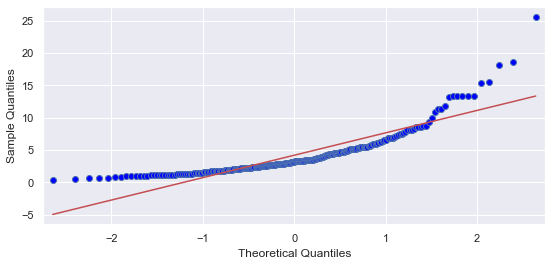

In [34]:
sm.ProbPlot(df_nanigans_conv_only['CPA']).qqplot(line='s');

### The above plots show that the Nanigans distribution is clearly right-skewed due to some poorly performing ad groups

In [35]:
# Extracting Day of the Week to see any trends based on day of the week

df_nanigans_wkday = df_nanigans.drop(columns=['CPM','CPC','CPA']).resample('D').sum()
df_nanigans_wkday['CPA'] = round(df_nanigans_wkday['spent'] / df_nanigans_wkday['conversions'], 2)
df_nanigans_wkday['weekday'] = pd.DatetimeIndex(df_nanigans_wkday.index).to_series().dt.day_name()
df_nanigans_wkday.head()

,spent,impressions,clicks,conversions,CPA,weekday
date,,,,,,
2017-11-14,511.00,19604,275,119,4.29,Tuesday
2017-11-15,505.12,18681,265,107,4.72,Wednesday
2017-11-16,455.20,18175,237,94,4.84,Thursday
2017-11-17,516.59,21008,368,170,3.04,Friday
2017-11-18,508.36,21932,474,246,2.07,Saturday


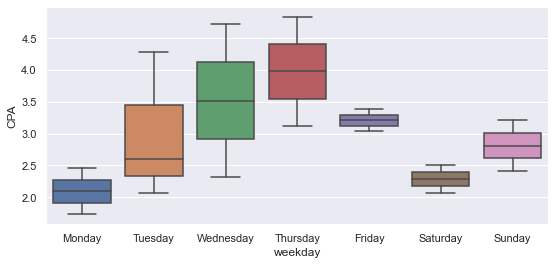

In [36]:
# Visualizing CPA by Day of the Week

sns.set(rc={'figure.figsize':(9, 4)})
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.boxplot(x="weekday", y="CPA", data=df_nanigans_wkday, order=order)
plt.show()

#### Here we can see that Nanigan's daily CPA varies more than Smartly throughout the week in the range of  \\$1.80 - \\$4.80


In [37]:
nanigans_tot_spend = df_nanigans['spent'].sum()
nanigans_tot_conv = df_nanigans['conversions'].sum()
nanigans_cpa = nanigans_tot_spend / nanigans_tot_conv

print('In total, Nanigans spent ${0:.2f} on this ad study which generated {1} conversions and a CPA of ${2:.2f}'.format(nanigans_tot_spend,nanigans_tot_conv, nanigans_cpa))

In total, Nanigans spent $5911.35 on this ad study which generated 2182 conversions and a CPA of $2.71


In [38]:
# Sample calculation using a product priced at $10 

product_price = 10 # must be same as Smartly product to compare
ROAS = return_on_ad_spend(nanigans_tot_spend, nanigans_tot_conv, product_price)

print('For every dollar spent on ads, Nanigans generated ${0:.2f} in revenue'.format(ROAS))

For every dollar spent on ads, Nanigans generated $3.69 in revenue


#### For this sample product that sells for \\$10 , Nanigans brought in ~15% less in revenue per dollar spent than Smartly's campaigns

----

# 3) Making comparisons and checking significance

### Visualizing ad spend between the two FMPs

In [43]:
TOOLS = 'crosshair,save,pan,box_zoom,reset,wheel_zoom'
p = figure(title="Ad Spend", y_axis_type="linear",x_axis_type='datetime', tools = TOOLS)

p.circle(df_smartly.index, df_smartly.spent, legend="Smartly", line_color="purple", line_width = 3)
p.circle(df_nanigans.index, df_nanigans.spent, legend="Nanigans", line_color="blue", line_width = 3)

p.legend.location = "top_left"

p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Ad Spend (USD)'

show(p)

## Visualizing Clicks between the two FMPs

In [44]:
TOOLS = 'crosshair,save,pan,box_zoom,reset,wheel_zoom'
p = figure(title="Clicks", y_axis_type="linear",x_axis_type='datetime', tools = TOOLS)

p.circle(df_smartly.index, df_smartly.clicks, legend="Smartly", line_color="purple", line_width = 3)
p.circle(df_nanigans.index, df_nanigans.clicks, legend="Nanigans", line_color="blue", line_width = 3)

p.legend.location = "top_left"

p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Clicks'

show(p)

## Visualizing Conversions between Smartly & Nanigans

In [45]:
TOOLS = 'crosshair,save,pan,box_zoom,reset,wheel_zoom'
p = figure(title="Conversions", y_axis_type="linear",x_axis_type='datetime', tools = TOOLS)

p.circle(df_smartly.index, df_smartly.conversions, legend="Smartly", line_color="purple", line_width = 3)
p.circle(df_nanigans.index, df_nanigans.conversions, legend="Nanigans", line_color="blue", line_width = 3)

p.legend.location = "top_left"

p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Conversions (Click-Through only)'

show(p)

## Comparing the CPA performance between Smartly & Nanigans and determining significance 

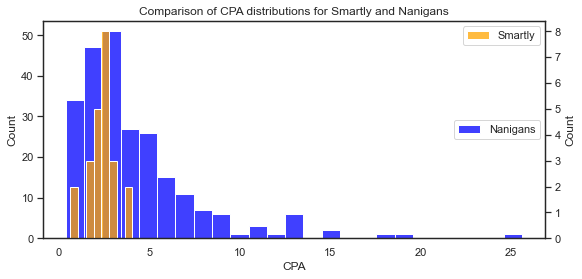

In [41]:
# Plotting both distributions (from above) together for comparison

sns.set_style(style='white')
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.histplot(df_smartly['CPA'], color='orange', label='Smartly', ax=ax2)
sns.histplot(df_nanigans_conv_only['CPA'], color='blue', label='Nanigans', ax=ax1)
ax2.legend(loc=0)
ax1.legend(loc=7)
plt.title('Comparison of CPA distributions for Smartly and Nanigans');

### These distributions look quite dissimilar and as seen above, also not normaly distributed

### I had originally planned on using an independent t-test, however, because an independent t-test requires the assumption of normality, we'll instead look at its nonparametric cousin -- Mann-Whitney U Test

### H0: No difference in the two sample distributions
### H1: Sample distributions are not equal

In [42]:
# compare samples
stat, p = mannwhitneyu(df_smartly['CPA'],df_nanigans_conv_only['CPA'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=1879.000, p=0.006
Different distribution (reject H0)


----

# 4) Conclusions & Insights

1) Which FMP gave the best results in terms of <b>CPA</b>?

     - Smartly mean CPA: $2.41
     - Nanigans mean CPA: $2.71
    
   Based on these numbers, it seems that Smartly performed better. 
    
2) Comparison plots can be seen above in the notebook

I chose to visualize Ad Spend, Clicks, and Conversions for both FMPs over the course of the study.
Smartly ran far fewer ads with larger budgets per ad than Nanigans, but each of their ad groups generated much higher engagement (clicks) and coverted better. While Nanigans used the approach of super granular ads and microtargeting, Smartly appears to have done a better job at targeting much larger audiences while maintaining high conversion rates.     

3) How did you evaluate statistical significance? Was the result significant? Why is this important?

This is described in detail above. The difference in CPA was significant. I used the nonparametric Mann-Whitney U test because the distributions did not appear normal (a requirement of ind ttest). Significance is important because it tells you whether a result (in this case differences in our mean CPA's) was simply due to chance or to some factor of interest. 

4) Additional insights

    - Smartly outperformed Nanigans in ROAS (using an imaginary product w/ an arbitrary price of \\$10)
    - The client using Smartly would have had to spend MUCH less time creating ads to achieve better results 
    - Nanigans wasted \\$111.85 on 25 ad groups that didn't convert 
    - Nanigans wasted time creating 34 ad groups that didn't even generate clicks
    - Plotting click through rate over time could be interesting
    - Visualizing metrics by individual adgroups could provide additional insights
    - Smartly seems like a far more efficient and effective FMP